# DATA Processing

### Import libraries

In [2]:
from plotly import graph_objs as go
from plotly import express as px
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import pywt.data
from scipy import*
from datetime import datetime
from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_absolute_percentage_error

pd.options.plotting.backend = "plotly"

#from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import savgol_filter

## Optical Response

### Loading data

In [3]:
# Function for cleaning
def PM100D_data(file_names: list) -> pd.DataFrame:
    dt = pd.DataFrame()
    for name, index in zip(file_names, np.arange(1, len(file_names)+1)):
        data_optic_response = pd.read_excel(f'{name}', header = None)
        data_optic_response['Timestamp'] = pd.to_timedelta(data_optic_response.iloc[15:, 2]).dt.total_seconds()
        data_optic_response['Timestamp'] = data_optic_response['Timestamp'] - data_optic_response.iloc[15, 5]
        dt[f'optic_response_{index}_Time_s'] = data_optic_response.iloc[15:, 5]
        dt[f'optic_response_{index}_Power_W'] = data_optic_response.iloc[15:, 3]
    dt = dt.reset_index().drop(['index'], axis=1)
    return dt

# Function for cleaning
def PM320_data(file_names: list) -> pd.DataFrame:
    dt = pd.DataFrame()
    for name, index in zip(file_names, np.arange(1, len(file_names)+1)):
        data_optic_response = pd.read_table(f'{name}', header = None, sep = r"\s+")
        dt[f'optic_response_{index}_Time_s'] = data_optic_response.index.values
        dt[f'optic_response_{index}_Power_W'] = data_optic_response.drop([0, 1, 2, 3, 4, 5, 7, 8], axis=1).rename(columns={6: 'Power_dshape'})
        #dt[f'data_optic_response_{index}_Power_ASE'] = data_optic_response.drop([0, 1, 2, 4, 5, 6, 7, 8], axis=1).rename(columns={3: 'Power_ASE'})
    return dt

# Function for cleaning
def old_PM100D_data(file_names: list) -> pd.DataFrame:
    dt = pd.DataFrame()
    for name, index in zip(file_names, np.arange(1, len(file_names)+1)):
        data_optic_response = pd.read_excel(f'{name}', header = None)
        data_optic_response = data_optic_response.iloc[23:, 0:2].rename(columns={0: 'Time_ms', 1: 'Power_W'}).reset_index().drop(['index'], axis=1)
        dt[f'optic_response_{index}_Time_ms'] = data_optic_response.iloc[:, 0]
        dt[f'optic_response_{index}_Power_W'] = data_optic_response.iloc[:, 1]
    return dt

In [10]:
# Input parameters for PM320_data:
file_names_optic = [r'optic_data_20_09_23_new_CNT_NO2_RH0.xlsx',
                    r'optic_data_20_09_23_new_CNT_NO2_RH30.xlsx',
                    r'optic_data_20_09_23_new_CNT_NO2_RH50.xlsx']


In [11]:
optic_data = PM100D_data(file_names_optic)
optic_data.head()

optic_response_1_Time_s optic_response_1_Power_W  optic_response_2_Time_s  \
0                    0.000                 0.006694                    0.000   
1                    1.034                 0.006695                    1.027   
2                    2.064                 0.006694                    2.038   
3                    3.072                 0.006695                    3.060   
4                    4.080                 0.006695                    4.085   

  optic_response_2_Power_W  optic_response_3_Time_s optic_response_3_Power_W  
0                 0.006753                    0.000                 0.006801  
1                 0.006754                    1.032                 0.006801  
2                 0.006755                    2.032                   0.0068  
3                 0.006755                    3.052                 0.006799  
4                 0.006755                    4.077                 0.006799

### Transmittance

In [12]:
# Initial parameters
time_cycle = 6 # min
not_taken_number_cycles = 1
taken_number_cycles = 8
Power_before_dshape = 0.01123

In [13]:
# Function for creating transmittance data PM100D
def Transmittance_create_data(data: pd.DataFrame):
    Transmittance_norm = pd.DataFrame()
    count = 1
    for n in np.arange(0, len(data.columns), 2):
        Transmittance_0 = data.iloc[0, n+1]
        Transmittance_norm[f'Optic_response_{count}_Transmit'] = (data.iloc[:, n+1] - Transmittance_0) / Transmittance_0
        count += 1
    return Transmittance_norm

# Function for creating time data
def Time_create_data(data):
    Time = pd.DataFrame()
    count = 1
    for n in np.arange(0, len(data.columns), 2):
        Time[f'{count}_Time'] = data.iloc[:, n]
        count += 1
    return Time

In [14]:
Transmittance_norm_data = Transmittance_create_data(optic_data)
Transmittance_norm_data.head()

Optic_response_1_Transmit Optic_response_2_Transmit  \
0                       0.0                       0.0   
1                  0.000254                  0.000193   
2                   0.00012                  0.000222   
3                  0.000194                  0.000237   
4                  0.000269                  0.000355   

  Optic_response_3_Transmit  
0                       0.0  
1                  0.000015  
2                 -0.000147  
3                 -0.000191  
4                 -0.000206

In [15]:
Time_data_T = Time_create_data(optic_data)
Time_data_T.head()

1_Time  2_Time  3_Time
0   0.000   0.000   0.000
1   1.034   1.027   1.032
2   2.064   2.038   2.032
3   3.072   3.060   3.052
4   4.080   4.085   4.077

### Data Visualization 

In [21]:
# plotting raw data
def quick_plot_T(data: pd.DataFrame, Time_data, time_cycle) -> None:
    fig = go.Figure()
    
    # Making colour for each data
    humidity = [0, 30, 50]
    color_dict = dict(zip(humidity, sample_colorscale('Portland', minmax_scale(humidity))))

    # Creating line plots from data
    for column, humid, count in zip(data.columns.values, humidity, np.arange(0, len(data.columns.values), 1)):
        minutes = Time_data.iloc[:, count].values / 60
        fig.add_trace(go.Scattergl(x = minutes, 
                                   y = data.loc[:,column].values, 
                                   name = str(f'{humid}% humidity'),
                                   line_color = color_dict[humid]))

    # Creating vertical rectangles
    for i in np.arange(time_cycle/2 +0.15, max(Time_data.max())/60, time_cycle):
        fig.add_vrect(x0=i,
                      x1=i + 3,
                      line_width=0,
                      fillcolor='grey',
                      opacity=0.1,
                      annotation_text='<i>NO<sub>2</sub></i>',
                      annotation_font_size=20,
                      annotation_textangle=270,
                      annotation_position='top',)

    # Updating layout data
    fig.update_layout(font_size = 15,
                      title = f"CNT film T=80%, S11=1.5 \u03BCm.  date: 20.09.23 <br>Mixture: Air (100 sccm) <--> 50 ppm NO<sub>2</sub> (50 sccm) + Air (50 sccm) RH 0%.",
                      legend_title = "Measurement<br>parameters",
                      legend_font_size = 15,
                      xaxis_title = "Time, min",
                      yaxis_title = "Transmittance, \u0394T / T0",
                      #yaxis_type = 'log',
                      plot_bgcolor = 'rgba(250,250,250,1)',
                      width = 950,
                      height = 650,
                      )
    fig.add_shape(type="rect",
                  xref="paper",
                  yref="paper",
                  x0=0,
                  y0=0,
                  x1=1.0,
                  y1=1.0,
            line=dict(
                color="black",
                 width=1,))
    fig.show()

In [22]:
#quick_plot_T(pd.DataFrame(1 - np.log10(Transmittance_norm_data.iloc[1:, 0].astype(float)*100)), Time_data_T[Time_data_T.iloc[:, 1] < 3800], time_cycle)

In [60]:
quick_plot_T(Transmittance_norm_data, Time_data_T[Time_data_T.iloc[:, 0] < 3780], time_cycle)

---

### Violin Plots

In [33]:
def print_dt_metrics(Time_data: pd.DataFrame, humidity=[0, 30, 50]):
    try:
        dt = Time_data.diff().dropna()
        time_dt = pd.DataFrame()
        for index, humid in zip(range(0, len(Time_data.columns)), humidity):
            # dt - time between two neighboring datapoints [in seconds]
            time_dt.loc[f'{humid}', 'mean'] = dt.describe().iloc[1, index]
            time_dt.loc[f'{humid}', 'std'] = dt.describe().iloc[2, index]
            
            MAPE = mean_absolute_percentage_error(dt.iloc[:, index], np.array([dt.describe().iloc[1, index]] * len(dt)))
            time_dt.loc[f'{humid}', 'MAPE'] = MAPE * 100 # in percentages %
        
        return time_dt
    except AttributeError:
        print("Cannot calculate metrics: no Time_sec column. Wrong dataframe? Need raw dataframe from load_data")

In [34]:
print_dt_metrics(Time_data_T)

mean       std      MAPE
0   0.999908  0.095535  5.725087
30  0.999962  0.095484  5.773259
50  0.999930  0.097341  5.964061

In [35]:
def violin_plot(Time_data: pd.DataFrame):
  data_metrics = print_dt_metrics(Time_data)
  for index in range(0, len(Time_data.columns)):

    fig = px.scatter(x = Time_data.iloc[1:, index].dropna(), y = Time_data.diff().iloc[:, index].dropna(), marginal_y = "violin")
    # Updating layout data
    fig.update_layout(font_size = 15,
                      title = f"dt = {data_metrics.iloc[index, 0]:.2f} \u00b1 {data_metrics.iloc[index, 1]:.3f} seconds <br> MAPE = {data_metrics.iloc[index, 2]:.2f} %",
                      title_x=0.5,
                      legend_title = "Measurement<br>parameters",
                      legend_font_size = 15,
                      xaxis_title = "Time, s",
                      yaxis_title = "Time difference between datapoints, s",
                      hovermode = False,
                      plot_bgcolor = 'rgba(250,250,250,1)',
                      width = 1200,
                      height = 650,
                      )
    fig.add_shape(type="rect",
                  xref="paper",
                  yref="paper",
                  x0=0,
                  y0=0,
                  x1=1.0,
                  y1=1.0,
            line=dict(
                color="black",
                 width=1,))

    fig.show()

In [36]:
violin_plot(Time_data_T)

---

### Computing Sensor Signal

In [37]:
def sensor_signal(data: pd.DataFrame, name, search_delta=60):
        
    Sensor_signal = pd.DataFrame()
    for index in range(0, len(data.columns), 2):

        #Calculating Sensor signal
        if name == 'Resistance':
            # Min values of air:
            first_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(540, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Max values of gas:
            second_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(720, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Sensor signal calculation
            Sensor_signal[f'SS_{(index//2)+1}'] = [((Air_value/Gas_value) - 1) for Air_value, Gas_value in zip(first_3_min, second_3_min)]

        elif name == 'Transmittance':
            # Min values of air:
            first_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(540, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Max values of gas:
            second_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(720, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Sensor signal calculation
            Sensor_signal[f'SS_{(index//2)+1}'] = [((Gas_value/Air_value) - 1) for Air_value, Gas_value in zip(first_3_min, second_3_min)]
            
    return Sensor_signal


In [38]:
Optic_Sensor_signal = sensor_signal(optic_data, name='Transmittance')
Optic_Sensor_signal

SS_1      SS_2      SS_3
0  0.004900  0.007640  0.007566
1  0.004566  0.006962  0.007059
2  0.004755  0.006792  0.006848
3  0.004885  0.006768  0.006958
4  0.004984  0.006951  0.007084
5  0.005096  0.006755  0.006932
6  0.005550  0.006910  0.007102
7  0.005395  0.006668  0.006849
8  0.005522  0.006645  0.007047

In [39]:
# Calculating statistics of sensor signal
def ss_statistic(data: pd.DataFrame, humidity=[0, 30, 50]):
    SS_statistic = pd.DataFrame()
    SS_statistic['Humidity'] = humidity

    for index in range(0, len(data.columns)):
        SS_statistic.loc[index, 'mean'] = data.describe().iloc[1, index]
        SS_statistic.loc[index, 'std'] = data.describe().iloc[2, index]

    SS_statistic = SS_statistic.set_index('Humidity')    
    return SS_statistic

In [40]:
SS_optic_statistic = ss_statistic(Optic_Sensor_signal)
SS_optic_statistic

mean       std
Humidity                    
0         0.005072  0.000347
30        0.006899  0.000301
50        0.007049  0.000216

### Sensor Signal Visualization

In [43]:
def statistics_plot(data):
    fig = px.scatter(data, y = 'mean', error_y = 'std', trendline = 'ols', color_discrete_sequence=['darkblue'])
    results = px.get_trendline_results(fig).iloc[0]["px_fit_results"]
    a = results.params[1]
    b = results.params[0]
    R2 = results.rsquared

    # Updating layout data
    fig.update_layout(font_size = 15,
                        title = f'Optical Sensor signal statistics <br>y = {a:.3f}x + {b:.3f}, R<sup>2</sup> = {R2:.2f}',
                        legend_title = "Measurement<br>parameters",
                        legend_font_size = 15,
                        xaxis_title = "Humidity, %",
                        yaxis_title = "Mean Sensor Signal \u0394T / T0",
                        #yaxis_type = 'log',
                        plot_bgcolor = 'rgba(250,250,250,1)',
                        width = 950,
                        height = 650,
                        )
    fig.add_shape(type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
            line=dict(
                color="black",
                    width=1,))
    fig.show()

In [44]:
statistics_plot(SS_optic_statistic)

---

### Computing LOD (Limit of Detection)

In [45]:
# you can use any filter, starting from moving average and LOWESS. Here is an exemplar implementation of Savitzky-Golay filter
def smooth(raw_data: pd.Series, window_length: int = 100, polyorder: int = 3) -> (pd.Series, list):
  index = raw_data.index.values
  filtered = savgol_filter(raw_data, window_length = window_length, polyorder = polyorder, mode = 'mirror')
  noise = [x - y for x, y in zip(filtered, raw_data.values.tolist())]
  return pd.Series(data = filtered, index = index), noise

In [46]:
def LOD_calculation(data: pd.DataFrame, Sensor_signal: pd.DataFrame, name, Gas_ppm=50, search_delta=60, time_cycle=3, humidity=[0, 30, 50]):
    LOD_data = pd.DataFrame()
    # Extracting Noise data
    for index, humid in zip(range(0, len(data.columns), 2), humidity):
        smooth_data, Noise = smooth(data.iloc[:, index+1], 70)
        Noise = pd.DataFrame(Noise).dropna()
        RMSE_value = np.sqrt(sum([(x - Noise.mean()) ** 2 for x in Noise]) / len(Noise))

        
        if name == 'Resistance':
            # Computing mean Air_transmittance:
            Air_value = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(180, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]
            
            # Computing SS_LOD:
            SS_LOD = (3*RMSE_value) / np.mean(Air_value)
            # Computing LOD:
            LOD_data[humid] = ((SS_LOD * Gas_ppm) / Sensor_signal.iloc[:, index//2].mean()) * 100

        elif name == 'Transmittance':
            # Computing mean Air_transmittance
            Air_value = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(180, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Computing SS_LOD:
            SS_LOD = (3*RMSE_value) / np.mean(Air_value)
            # Computing LOD:
            LOD_data[humid] = ((SS_LOD * Gas_ppm) / Sensor_signal.iloc[:, index//2].mean()) * 100
     
    return LOD_data

In [47]:
LOD_data = LOD_calculation(optic_data, Optic_Sensor_signal, name='Transmittance')
LOD_data

0         30        50
0  0.075262  0.071901  0.069267

---

# DATA Processing

### Resistance Response

### Loading data

In [48]:
# Function for cleaning
def Resistance_data(file_names: list) -> pd.DataFrame:
    dt = pd.DataFrame()
    for name, index in zip(file_names, np.arange(1, len(file_names)+1)):
        data_resist_response = pd.read_excel(f'{name}', header = None)
        data_resist_response = data_resist_response.rename(columns={'Unnamed: 3': 'Resistance', 'Unnamed: 0': 'Time'})
        dt[f'resist_response_{index}_Time_s'] = data_resist_response.iloc[7:, 0].reset_index().drop(['index'], axis=1).astype(float)
        dt[f'resist_response_{index}_Resistance_Ohms'] = data_resist_response.iloc[7:, 3].reset_index().drop(['index'], axis=1).astype(float)
    return dt

In [50]:
# Input parameters for PM320_data:
file_names_resist = [r'resist_data_20_09_23_new_CNT_NO2_RH0.xlsx',
                     r'resist_data_20_09_23_new_CNT_NO2_RH30.xlsx',
                     r'resist_data_20_09_23_new_CNT_NO2_RH50.xlsx']

In [51]:
resist_data = Resistance_data(file_names_resist)
resist_data.head()

resist_response_1_Time_s  resist_response_1_Resistance_Ohms  \
0                     0.000                        4334.985107   
1                     1.252                        4329.722201   
2                     1.688                        4334.985107   
3                     2.090                        4337.623243   
4                     2.524                        4340.262707   

   resist_response_2_Time_s  resist_response_2_Resistance_Ohms  \
0                     0.000                        3601.541316   
1                     1.254                        3607.006538   
2                     1.660                        3610.658375   
3                     2.069                        3601.541316   
4                     2.475                        3608.831533   

   resist_response_3_Time_s  resist_response_3_Resistance_Ohms  
0                     0.000                        3344.771336  
1                     1.258                        3343.202467  
2                     1.682                        3341.636185  
3                     2.120                        3340.071371  
4                     2.538                        3340.071371

### Resistance Normalization

In [54]:
# Function for creating transmittance data PM100D
def Resistance_create_data(data: pd.DataFrame):
    Resistance_norm = pd.DataFrame()
    count = 1
    for n in np.arange(0, len(data.columns), 2):
        Resistance_0 = data.iloc[0, n+1]
        Resistance_norm[f'Resist_response_{count}_R_Norm'] = (data.iloc[:, n+1] - Resistance_0) / Resistance_0
        count += 1
    return Resistance_norm

# Function for creating time data
def Time_create_data(data):
    Time = pd.DataFrame()
    count = 1
    for n in np.arange(0, len(data.columns), 2):
        Time[f'{count}_Time'] = data.iloc[:, n]
        count += 1
    return Time

In [55]:
Resistance_norm_data = Resistance_create_data(resist_data)
Resistance_norm_data.head()

Resist_response_1_R_Norm  Resist_response_2_R_Norm  \
0                  0.000000                  0.000000   
1                 -0.001214                  0.001517   
2                  0.000000                  0.002531   
3                  0.000609                  0.000000   
4                  0.001217                  0.002024   

   Resist_response_3_R_Norm  
0                  0.000000  
1                 -0.000469  
2                 -0.000937  
3                 -0.001405  
4                 -0.001405

In [56]:
Time_data_R = Time_create_data(resist_data)
Time_data_R.head()

1_Time  2_Time  3_Time
0   0.000   0.000   0.000
1   1.252   1.254   1.258
2   1.688   1.660   1.682
3   2.090   2.069   2.120
4   2.524   2.475   2.538

In [57]:
# plotting raw data
def quick_plot_R(data: pd.DataFrame, Time_data, time_cycle) -> None:
    fig = go.Figure()
    
    # Making colour for each data
    humidity = [0, 30, 50]
    color_dict = dict(zip(humidity, sample_colorscale('Portland', minmax_scale(humidity))))

    # Creating line plots from data
    for column, humid, count in zip(data.columns.values, humidity, np.arange(0, len(data.columns.values), 1)):
        minutes = Time_data.iloc[:, count].values / 60
        fig.add_trace(go.Scattergl(x = minutes, 
                                   y = data.loc[:,column].values, 
                                   name = str(f'{humid}% humidity'),
                                   line_color = color_dict[humid]))

    # Creating vertical rectangles
    for i in np.arange(time_cycle/2 +0.15, max(Time_data.max())/60, time_cycle):
        fig.add_vrect(x0=i,
                      x1=i + 3,
                      line_width=0,
                      fillcolor='grey',
                      opacity=0.1,
                      annotation_text='<i>NO<sub>2</sub></i>',
                      annotation_font_size=20,
                      annotation_textangle=270,
                      annotation_position='top',)

    # Updating layout data
    fig.update_layout(font_size = 15,
                      title = f"CNT film T=80%, S11=1.5 \u03BCm.   date: 20.09.23 <br>Mixture: Air (100 sccm) <--> 50 ppm NO<sub>2</sub> (50 sccm) + Air (50 sccm) RH 0%",
                      legend_title = "Measurement<br>parameters",
                      legend_font_size = 15,
                      xaxis_title = "Time, min",
                      yaxis_title = "Resistance, \u0394R / R0",
                      #yaxis_type = 'log',
                      plot_bgcolor = 'rgba(250,250,250,1)',
                      width = 950,
                      height = 650,
                      )
    fig.add_shape(type="rect",
                  xref="paper",
                  yref="paper",
                  x0=0,
                  y0=0,
                  x1=1.0,
                  y1=1.0,
            line=dict(
                color="black",
                 width=1,))
    fig.show()

In [58]:
quick_plot_R(Resistance_norm_data, Time_data_R[Time_data_R.iloc[:, 0] < 3780], time_cycle)

---

### Violin Plots

In [61]:
def print_dt_metrics(Time_data: pd.DataFrame, humidity=[0, 30, 50]):
    try:
        dt = Time_data.diff().dropna()
        time_dt = pd.DataFrame()
        for index, humid in zip(range(0, len(Time_data.columns)), humidity):
            # dt - time between two neighboring datapoints [in seconds]
            time_dt.loc[f'{humid}', 'mean'] = dt.describe().iloc[1, index]
            time_dt.loc[f'{humid}', 'std'] = dt.describe().iloc[2, index]
            
            MAPE = mean_absolute_percentage_error(dt.iloc[:, index], np.array([dt.describe().iloc[1, index]] * len(dt)))
            time_dt.loc[f'{humid}', 'MAPE'] = MAPE * 100 # in percentages %
        
        return time_dt
    except AttributeError:
        print("Cannot calculate metrics: no Time_sec column. Wrong dataframe? Need raw dataframe from load_data")

In [62]:
print_dt_metrics(Time_data_R)

mean       std      MAPE
0   0.406431  0.011284  1.297418
30  0.406686  0.011443  1.320878
50  0.406762  0.011384  1.344481

In [63]:
def violin_plot(Time_data: pd.DataFrame):
  data_metrics = print_dt_metrics(Time_data)
  for index in range(0, len(Time_data.columns)):

    fig = px.scatter(x = Time_data.iloc[1:, index].dropna(), y = Time_data.diff().iloc[:, index].dropna(), marginal_y = "violin")
    # Updating layout data
    fig.update_layout(font_size = 15,
                      title = f"dt = {data_metrics.iloc[index, 0]:.2f} \u00b1 {data_metrics.iloc[index, 1]:.3f} seconds <br> MAPE = {data_metrics.iloc[index, 2]:.2f} %",
                      title_x=0.5,
                      legend_title = "Measurement<br>parameters",
                      legend_font_size = 15,
                      xaxis_title = "Time, s",
                      yaxis_title = "Time difference between datapoints, s",
                      hovermode = False,
                      plot_bgcolor = 'rgba(250,250,250,1)',
                      width = 1200,
                      height = 650,
                      )
    fig.add_shape(type="rect",
                  xref="paper",
                  yref="paper",
                  x0=0,
                  y0=0,
                  x1=1.0,
                  y1=1.0,
            line=dict(
                color="black",
                 width=1,))

    fig.show()

In [67]:
violin_plot(Time_data_R.iloc[1:, :])

---

### Computing Sensor Signal

In [73]:
def sensor_signal(data: pd.DataFrame, name, search_delta=60):
        
    Sensor_signal = pd.DataFrame()
    for index in range(0, len(data.columns), 2):

        #Calculating Sensor signal
        if name == 'Resistance':
            # Min values of air:
            first_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(540, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Max values of gas:
            second_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(720, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Sensor signal calculation
            Sensor_signal[f'SS_{(index//2)+1}'] = [((Air_value/Gas_value) - 1) for Air_value, Gas_value in zip(first_3_min, second_3_min)]

        elif name == 'Transmittance':
            # Min values of air:
            first_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(540, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Max values of gas:
            second_3_min = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(720, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Sensor signal calculation
            Sensor_signal[f'SS_{(index//2)+1}'] = [((Gas_value/Air_value) - 1) for Air_value, Gas_value in zip(first_3_min, second_3_min)]
            
    return Sensor_signal


In [74]:
Resist_Sensor_signal = sensor_signal(resist_data, name='Resistance')
Resist_Sensor_signal

SS_1      SS_2      SS_3
0  0.098875  0.100390  0.089448
1  0.086108  0.090172  0.078038
2  0.087275  0.088304  0.077215
3  0.090608  0.088044  0.080888
4  0.091007  0.086917  0.079220
5  0.092070  0.086191  0.079261
6  0.091527  0.085078  0.078958
7  0.089094  0.083113  0.077791
8  0.089447  0.080330  0.076217

In [75]:
# Calculating statistics of sensor signal
def ss_statistic(data: pd.DataFrame, humidity=[0, 30, 50]):
    SS_statistic = pd.DataFrame()
    SS_statistic['Humidity'] = humidity

    for index in range(0, len(data.columns)):
        SS_statistic.loc[index, 'mean'] = data.describe().iloc[1, index]
        SS_statistic.loc[index, 'std'] = data.describe().iloc[2, index]

    SS_statistic = SS_statistic.set_index('Humidity')    
    return SS_statistic

In [76]:
SS_resist_statistic = ss_statistic(Resist_Sensor_signal, [10, 30, 50])
SS_resist_statistic

mean       std
Humidity                    
10        0.090668  0.003648
30        0.087616  0.005620
50        0.079671  0.003907

### Sensor Signal Visualization

In [77]:
def statistics_plot(data):
    fig = px.scatter(data, y = 'mean', error_y = 'std', trendline = 'ols', color_discrete_sequence=['darkblue'])
    results = px.get_trendline_results(fig).iloc[0]["px_fit_results"]
    a = results.params[1]
    b = results.params[0]
    R2 = results.rsquared

    # Updating layout data
    fig.update_layout(font_size = 15,
                        #title = f'Resistive Sensor signal statistics <br>y = {a:.3f}x + {b:.3f}, R<sup>2</sup> = {R2:.2f}',
                        legend_title = "Measurement<br>parameters",
                        legend_font_size = 15,
                        xaxis_title = "Humidity, %",
                        yaxis_title = "Mean Sensor Signal \u0394R / R0",
                        #yaxis_type = 'log',
                        plot_bgcolor = 'rgba(250,250,250,1)',
                        width = 950,
                        height = 650,
                        )
    fig.add_shape(type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
            line=dict(
                color="black",
                    width=1,))
    fig.show()

In [78]:
statistics_plot(SS_resist_statistic)

---

### Computing LOD

In [80]:
# you can use any filter, starting from moving average and LOWESS. Here is an exemplar implementation of Savitzky-Golay filter
def smooth(raw_data: pd.Series, window_length: int = 100, polyorder: int = 3) -> (pd.Series, list):
  index = raw_data.index.values
  filtered = savgol_filter(raw_data, window_length = window_length, polyorder = polyorder, mode = 'mirror')
  noise = [x - y for x, y in zip(filtered, raw_data.values.tolist())]
  return pd.Series(data = filtered, index = index), noise

In [81]:
def LOD_calculation(data: pd.DataFrame, Sensor_signal: pd.DataFrame, name, Gas_ppm=50, search_delta=60, time_cycle=3, humidity=[0, 30, 50]):
    LOD_data = pd.DataFrame()
    # Extracting Noise data
    for index, humid in zip(range(0, len(data.columns), 2), humidity):
        smooth_data, Noise = smooth(data.iloc[:, index+1], 70)
        Noise = pd.DataFrame(Noise).dropna()
        RMSE_value = np.sqrt(sum([(x - Noise.mean()) ** 2 for x in Noise]) / len(Noise))

        
        if name == 'Resistance':
            # Computing mean Air_transmittance:
            Air_value = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].max() for minutes_3_mark in range(180, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]
            
            # Computing SS_LOD:
            SS_LOD = (3*RMSE_value) / np.mean(Air_value)
            # Computing LOD:
            LOD_data[humid] = ((SS_LOD * Gas_ppm) / Sensor_signal.iloc[:, index//2].mean()) * 100

        elif name == 'Transmittance':
            # Computing mean Air_transmittance
            Air_value = [data.loc[(data.iloc[:, index] < (minutes_3_mark + search_delta)) & (data.iloc[:, index] > (minutes_3_mark - search_delta))].iloc[:, index+1].min() for minutes_3_mark in range(180, int(data.iloc[data.iloc[:, index].last_valid_index(), index]), time_cycle*60)]

            # Computing SS_LOD:
            SS_LOD = (3*RMSE_value) / np.mean(Air_value)
            # Computing LOD:
            LOD_data[humid] = ((SS_LOD * Gas_ppm) / Sensor_signal.iloc[:, index//2].mean()) * 100
     
    return LOD_data

In [82]:
LOD_data = LOD_calculation(resist_data, Resist_Sensor_signal, name='Resistance')
LOD_data

0         30        50
0  0.018266  0.015895  0.018384

---

### Response and Recovery Time

In [83]:
def response_recovery(data: pd.DataFrame, time_cycle=3) -> list:
  # Cuts Time data into pieces
  rec, res = [], []
  for index in range(540, int(data.iloc[data.iloc[:, 0].last_valid_index(), 0]), time_cycle*60*2):
    rec.append(data.iloc[index:index+180, 1].values.tolist())
    res.append(data.iloc[index+180:index+360, 1].values.tolist())
  return res, rec

1759    3848.381467
1760    3860.883115
1761    3856.706388
1762    3865.068899
1763    3867.164448
           ...     
2198    4079.549585
2199    4079.549585
2200    4081.884230
2201    4084.221549
2202    4093.599330
Name: resist_response_1_Resistance_Ohms, Length: 444, dtype: float64


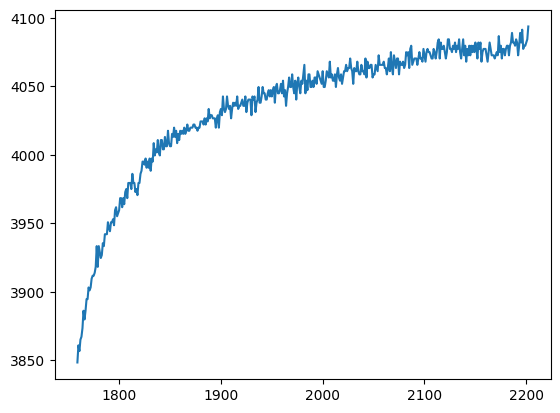

In [84]:
a = resist_data.loc[(resist_data.iloc[:, 0] < 532+362) & (resist_data.iloc[:, 0] > 532+182)].iloc[:, 1]
time_sec = np.arange(0, len(a))*0.4
print(a)
plt.plot(a)
plt.show()

In [85]:
resist_response, resist_recovery = response_recovery(resist_data)
print(len(resist_response), len(resist_response[0]))

10 180


In [86]:
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, y0):
  sigmoid = L/(1+np.exp(-k*(x-x0))) + y0
  return sigmoid

def inverse_sigmoid(y, L, x0, k, y0):
  return (1/k)*np.log((y-y0)/(L-y+y0)) + x0

In [87]:
# Fitting data and finding optimal parameters
xdata = np.array(time_sec)
ydata = np.array(a)
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=[max(ydata), np.median(xdata), 1, min(ydata)], maxfev=5000) #, bounds=([0, -np.inf, -np.inf],[np.inf, np.inf, 100]))
print(popt)

# Presentation of fitting data
x = np.arange(-10, 180, 0.01)
y = sigmoid(x, *popt)

fig = go.Figure()
fig.add_trace(go.Scatter(x=xdata, y=ydata, name='Raw data', mode = 'markers'))
fig.add_trace(go.Scatter(x=x, y=sigmoid(x, *popt), name=f'Fitted data', mode = 'lines')) #{popt}
fig.update_layout(font_size = 15,
                    title = f'Fitting time data',
                    legend_title = "Measurement<br>parameters",
                    legend_font_size = 15,
                    xaxis_title = "Time, s",
                    yaxis_title = "Resistance, Ohms",
                    #yaxis_type = 'log',
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1000,
                    height = 700,
                    )
fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.show()

target_value = 0.9 * (max(ydata) - ydata[0]) + ydata[0] if ydata[0] < ydata[-1] else ydata[0] - 0.9 * abs(min(ydata) - ydata[0])
print(target_value)

t90 = inverse_sigmoid(target_value, *popt)
print(t90)


[ 1.57976958e+06 -3.23320301e+02  2.78953322e-02 -1.57569529e+06]


4069.077543660149
129.16650278324238


In [88]:
1422177.4590638117
-1575917.0874089377

-1575917.0874089377

In [89]:
def fit_data(raw: list, dt: float = 0.4, plot: bool = False):
  time_sec = np.arange(0,len(raw))*dt
  p0 = [max(raw[0], raw[-1]), (raw[10]-raw[0])/1.6/11, 0]
  popt, pcov = curve_fit(sigmoid, time_sec, raw, p0 = p0, bounds=([0, -np.inf, -np.inf],[np.inf, np.inf, 100]))  ## bounds for L (supremum), k (slope), x0 (x displacement)
  if plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = time_sec, y = raw, name='raw_data', mode = 'markers'))
    fig.add_trace(go.Scatter(x = time_sec, y = [sigmoid(x,*popt) for x in time_sec], name=f'fitted_data<br>{popt}', mode = 'lines'))
    fig.update_layout()
    fig.show()
  target_value = 0.9*(popt[0]-raw[0])+raw[0] if raw[0] < raw[-1] else raw[0] - 0.9*abs(popt[0]-raw[0])
  t90 = inverse_sigmoid(target_value, *popt)
  return t90

C:\Users\79179\AppData\Local\Temp\ipykernel_36696\1075688825.py:8: RuntimeWarning:

divide by zero encountered in log



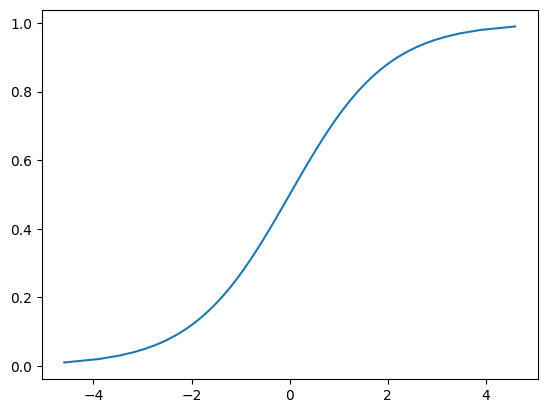

In [90]:
y = np.arange(0, 1, 0.01)
#plt.plot(x, sigmoid(x, L=1, k=1, x0=0, y0=0))
plt.plot(inverse_sigmoid(y, L=1, k=1, x0=0, y0=0), y)
plt.show()

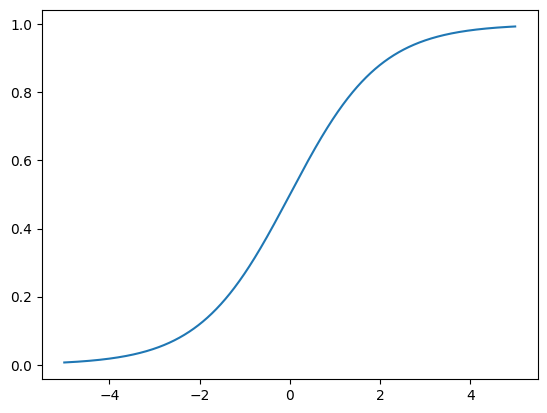

In [91]:
x = np.arange(-5, 5, 0.01)
plt.plot(x, sigmoid(x, L=1, k=1, x0=0, y0=0))
plt.show()

[7.23221637 1.33599425]


C:\Users\79179\AppData\Local\Temp\ipykernel_36696\322648833.py:6: RuntimeWarning:

overflow encountered in exp



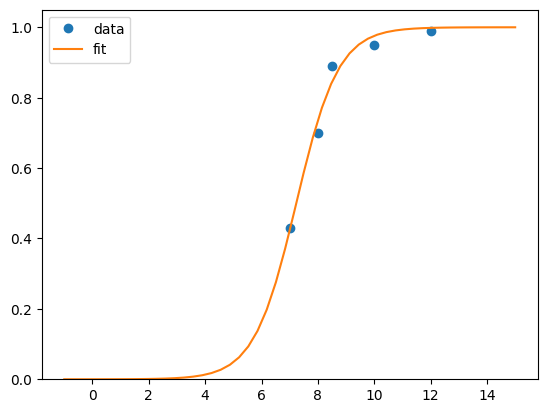

In [92]:
import numpy as np
import pylab
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

xdata = np.array([7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.43,  0.7, 0.89, 0.95, 0.99])

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(-1, 15, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [93]:
def fit_data(raw: list, dt: float = 0.4, plot: bool = False):
  time_sec = np.arange(0,len(raw))*dt
  p0 = [max(raw[0], raw[-1]), (raw[10]-raw[0])/1.6/11, 0]
  popt, pcov = curve_fit(sigmoid, time_sec, raw, p0 = p0, bounds=([0, -np.inf, -np.inf],[np.inf, np.inf, 100]))  ## bounds for L (supremum), k (slope), x0 (x displacement)
  if plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = time_sec, y = raw, name='raw_data', mode = 'markers'))
    fig.add_trace(go.Scatter(x = time_sec, y = [sigmoid(x,*popt) for x in time_sec], name=f'fitted_data<br>{popt}', mode = 'lines'))
    fig.update_layout()
    fig.show()
  target_value = 0.9*(popt[0]-raw[0])+raw[0] if raw[0] < raw[-1] else raw[0] - 0.9*abs(popt[0]-raw[0])
  t90 = inverse_sigmoid(target_value, *popt)
  return t90